# 207 Final Project
# Predicting Employee Attrition Using Decision Tree, KNN, and Logistic Regression

Class: 207 Applied Machine Learning | Spring 2023 <br>
Team: Ivy Chan, John Gibbons, Mark Herrera, Maria Manna 

# Import packages & mount drive


In [61]:
# run the below pip install if there's a problem importing heatmap
#!pip install mlxtend --upgrade

In [62]:
# standard libraries
import pandas as pd
import numpy as np
import os
import random

# visualizations
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
import mlxtend
from mlxtend.plotting import scatterplotmatrix
#from mlxtend.plotting import heatmap
from mlxtend.plotting import plot_decision_regions
import seaborn as sns

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss

# class imbalance
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN

# tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers

# display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


random.seed(2)

### Mount drive

In [63]:
#!pip install -U -q PyDrive

In [64]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)


Mounted at /content/drive


# Read data

In [65]:
df_original = pd.read_csv("/content/drive/MyDrive/207-MachineLearning/207_final_project/WA_Fn-UseC_-HR-Employee-Attrition.csv")

In [66]:
df = df_original.copy() # keep the original df

In [67]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager'], dtype='object')

In [68]:
df.shape
print("Shape of dataset: ", df.shape)


Shape of dataset:  (1470, 35)


# Pre-Processing

### Recode boolean variables

In [69]:
# Change Attrition variable to numeric - 1 for Yes, 0 for No
df.Attrition = np.where(df.Attrition == 'Yes', 1, 0)

In [70]:
# Change OverTime variable to numeric - 1 for Yes, 0 for No
df.OverTime = np.where(df.OverTime == 'Yes', 1, 0)

### Recode ordinal variables

In [71]:
# Change BusinessTravel variable (ordinal) to numeric - 0 for Non-Travel , 1 for Travel_Rarely, 2 for Travel_Frequently
travel_mapping = {'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2}
df.BusinessTravel = df.BusinessTravel.map(travel_mapping)

### Add one-hot encodings for nominal variables

In [72]:
# Create one-hot encodings for nominal variables (Gender, Department, EducationField, JobRole)
nominal_features = ['Gender', 'Department', 'EducationField', 'JobRole']

for feature in nominal_features:
  feature_dummies = pd.get_dummies(df[feature])
  feature_dummies.columns = feature_dummies.columns.str.replace(' ', '')
  feature_dummies = feature_dummies.add_prefix(feature.lower())
  df = pd.concat([df, feature_dummies], axis = 1)

print(df.shape)
print(df.columns.sort_values())

(1470, 55)
Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'departmentHumanResources', 'departmentResearch&Development', 'departmentSales', 'educationfieldHumanResources', 'educationfieldLifeSciences', 'educationfieldMarketing', 'educationfieldMedical', 'educationfieldOther', 'educationfieldTechnicalDegree', 'genderFemale', 'genderMale', 'jobroleHealthcareRepresentative', 'jobroleHumanResources', 'jobroleLaboratoryTechn

### Create subsets of features of interest

In [73]:
# Define list of all features of interest
all_features = ['Age', 'BusinessTravel', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'JobLevel', 'JobSatisfaction', 
                'MonthlyIncome', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'StockOptionLevel', 
                'TotalWorkingYears', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 
                'departmentHumanResources', 'departmentResearch&Development', 'departmentSales', 'educationfieldHumanResources', 
                'educationfieldLifeSciences', 'educationfieldMarketing', 'educationfieldMedical', 'educationfieldOther', 
                'educationfieldTechnicalDegree', 'genderFemale', 'genderMale', 'jobroleHealthcareRepresentative', 'jobroleHumanResources', 
                'jobroleLaboratoryTechnician', 'jobroleManager', 'jobroleManufacturingDirector', 'jobroleResearchDirector', 'jobroleResearchScientist', 
                'jobroleSalesExecutive', 'jobroleSalesRepresentative']

# Define list of features subset for more readable EDA
feature_subset = ['Age', 'EnvironmentSatisfaction', 'JobSatisfaction', 'StockOptionLevel', 
                  'WorkLifeBalance', 'departmentResearch&Development',
                  'MonthlyIncome'#, 'PerformanceRating'
                  #'MonthlyIncome', 'NumCompaniesWorked'
                  # 'MonthlyIncome', 'NumCompaniesWorked', 'OverTime' 
                  # 'MonthlyIncome', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike' 
                  # 'MonthlyIncome', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike','PerformanceRating' 
                  # 'MonthlyIncome', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike','PerformanceRating', 'YearsInCurrentRole'
                  #'MonthlyIncome', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike','PerformanceRating', 'YearsSinceLastPromotion' 
                  ]

In [74]:
print(len(all_features))
print(len(feature_subset))

39
7


### Train / Validation / Test Split

In [75]:
# Define feature and outcome arrays
X = df[all_features].values
X_sub = df[feature_subset].values
y = df.Attrition.values
print("Features shape: ", X.shape)
print("Feature sub shape: ", X_sub.shape)
print("Labels shape: ", y.shape)

Features shape:  (1470, 39)
Feature sub shape:  (1470, 7)
Labels shape:  (1470,)


In [76]:
# set seed for consistent behavior
np.random.seed(1234)

# Create test/validation/train split arrays for all features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                        random_state=1, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, 
                                                  random_state=1, stratify=y_train)

# Create test/validation/train split for features subset
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y, test_size=0.2, 
                                                                    random_state=1, stratify=y)

X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(X_train_sub, y_train_sub, test_size=0.2, 
                                                                  random_state=1, stratify=y_train_sub)

In [77]:
# print sizes of main train/test split
print('Size of X_train', X_train.shape)
print('Size of y_train', y_train.shape)
print('Size of X_val', X_val.shape)
print('Size of y_val', y_val.shape)
print('Size of X_test', X_test.shape)
print('Size of y_test', y_test.shape)


Size of X_train (940, 39)
Size of y_train (940,)
Size of X_val (236, 39)
Size of y_val (236,)
Size of X_test (294, 39)
Size of y_test (294,)


In [78]:
# print sizes of sub train/test splits
print('Size of X_train_sub', X_train_sub.shape)
print('Size of y_train_sub', y_train_sub.shape)
print('Size of X_val_sub', X_val_sub.shape)
print('Size of y_val_sub', y_val_sub.shape)
print('Size of X_test_sub', X_test_sub.shape)
print('Size of y_test_sub', y_test_sub.shape)

Size of X_train_sub (940, 7)
Size of y_train_sub (940,)
Size of X_val_sub (236, 7)
Size of y_val_sub (236,)
Size of X_test_sub (294, 7)
Size of y_test_sub (294,)


### Print summary statistics before standardizing

In [79]:
df_train_summary = pd.concat(
    [pd.DataFrame(y_train), pd.DataFrame(X_train)],
    axis=1
)

# Get column names
features_summary = all_features.copy()
features_summary.insert(0, 'Attrition')

# Assing column names
df_train_summary.columns = features_summary

# Add Attrition to feature subset for EDA
feature_subset_EDA = feature_subset.copy()
feature_subset_EDA.insert(0, 'Attrition')

# Subset summary df for more digestible output
df_train_summary = df_train_summary[feature_subset_EDA]

df_train_summary.describe().round(3)

,Attrition,Age,EnvironmentSatisfaction,JobSatisfaction,StockOptionLevel,WorkLifeBalance,departmentResearch&Development,MonthlyIncome
count,940.000,940.000,940.000,940.000,940.000,940.000,940.000,940.000
mean,0.162,37.076,2.706,2.763,0.816,2.753,0.657,6563.973
std,0.368,9.154,1.118,1.092,0.844,0.723,0.475,4700.521
min,0.000,18.000,1.000,1.000,0.000,1.000,0.000,1051.000
25%,0.000,30.000,2.000,2.000,0.000,2.000,0.000,2909.000
50%,0.000,36.000,3.000,3.000,1.000,3.000,1.000,4964.000
75%,0.000,43.000,4.000,4.000,1.000,3.000,1.000,8634.500
max,1.000,60.000,4.000,4.000,3.000,4.000,1.000,19999.000


### Standardize features

In [80]:
# Standardize features
sc_x = StandardScaler()
X_train_std = sc_x.fit(X_train).transform(X_train)
X_val_std = sc_x.fit(X_val).transform(X_val)
X_test_std = sc_x.fit(X_train).transform(X_test)

# Standardize subset features
X_train_std_sub = sc_x.fit(X_train_sub).transform(X_train_sub)
X_val_std_sub = sc_x.fit(X_val_sub).transform(X_val_sub)
X_test_std_sub = sc_x.fit(X_train_sub).transform(X_test_sub)

# EDA

### Create EDA dataframe

In [81]:
_# Create train df for EDA
df_train_eda = pd.concat(
    [pd.DataFrame(y_train), pd.DataFrame(X_train_std)],
    axis=1
)

features_eda = all_features.copy()
features_eda.insert(0, 'Attrition')

# Rename columns
df_train_eda.columns = features_eda

df_train_eda.head()

,Attrition,Age,BusinessTravel,DistanceFromHome,Education,EnvironmentSatisfaction,JobLevel,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,StockOptionLevel,TotalWorkingYears,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,departmentHumanResources,departmentResearch&Development,departmentSales,educationfieldHumanResources,educationfieldLifeSciences,educationfieldMarketing,educationfieldMedical,educationfieldOther,educationfieldTechnicalDegree,genderFemale,genderMale,jobroleHealthcareRepresentative,jobroleHumanResources,jobroleLaboratoryTechnician,jobroleManager,jobroleManufacturingDirector,jobroleResearchDirector,jobroleResearchScientist,jobroleSalesExecutive,jobroleSalesRepresentative
0,0,0.538246,-0.170851,-0.913412,0.102854,1.158051,-0.984391,-1.614845,-0.845244,-1.069496,1.679624,-1.143463,-0.428811,0.218131,-0.176062,0.341584,0.312474,0.461965,1.441298,1.079945,-0.202422,0.721828,-0.659632,-0.139724,-0.827398,-0.350797,1.475017,-0.254072,-0.313258,1.227464,-1.227464,-0.327391,-0.178418,2.191454,-0.279252,-0.33136,-0.241989,-0.491674,-0.536350,-0.241989
1,0,-0.991959,-0.170851,0.876596,-0.883707,0.262847,-0.072738,-1.614845,-0.426983,-0.666721,-0.595371,-0.871829,-0.428811,0.218131,-0.176062,0.341584,0.475565,-1.187074,-0.381330,1.079945,-0.202422,0.721828,-0.659632,-0.139724,-0.827398,-0.350797,1.475017,-0.254072,-0.313258,-0.814688,0.814688,-0.327391,-0.178418,2.191454,-0.279252,-0.33136,-0.241989,-0.491674,-0.536350,-0.241989
2,0,0.647547,-0.170851,-0.913412,0.102854,1.158051,-0.072738,1.133413,0.273099,-0.666721,1.679624,0.486340,-0.428811,0.218131,-0.176062,0.341584,0.475565,1.286484,1.745069,1.079945,-0.202422,-1.385372,1.515997,-0.139724,-0.827398,-0.350797,1.475017,-0.254072,-0.313258,-0.814688,0.814688,-0.327391,-0.178418,-0.456318,-0.279252,-0.33136,-0.241989,-0.491674,1.864454,-0.241989
3,0,-0.445457,1.718563,-0.555410,-1.870269,-0.632357,-0.072738,1.133413,0.730952,1.347154,-0.595371,-0.600195,-0.428811,-0.967089,-0.430283,1.725591,-0.339887,-0.087715,-0.381330,-0.599837,-0.202422,-1.385372,1.515997,-0.139724,1.208608,-0.350797,-0.677958,-0.254072,-0.313258,-0.814688,0.814688,-0.327391,-0.178418,-0.456318,-0.279252,-0.33136,-0.241989,-0.491674,1.864454,-0.241989
4,0,0.101045,1.718563,0.279927,0.102854,-1.527561,-0.072738,-1.614845,-0.058742,-0.263946,-0.595371,-0.056928,-0.428811,0.218131,0.205270,-1.042422,-0.502978,-0.362555,-0.381330,-0.599837,-0.202422,0.721828,-0.659632,-0.139724,1.208608,-0.350797,-0.677958,-0.254072,-0.313258,-0.814688,0.814688,3.054451,-0.178418,-0.456318,-0.279252,-0.33136,-0.241989,-0.491674,-0.536350,-0.241989


### Get distribution of target variable (Attrition)

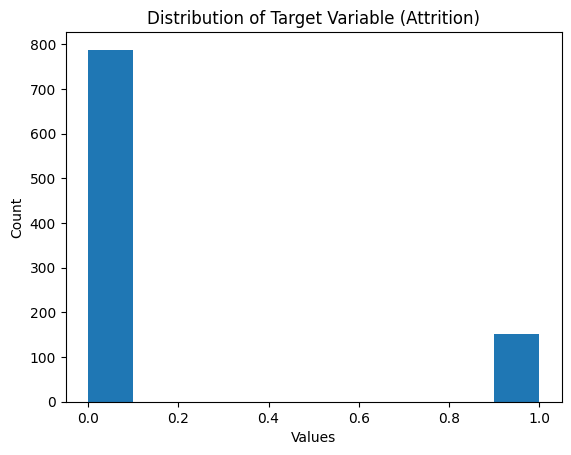

In [82]:
plt.hist(df_train_eda.Attrition)
plt.xlabel('Values')
plt.ylabel('Count')
plt.title('Distribution of Target Variable (Attrition)')
plt.show()

This indicates a significant class imbalance which will be addressed later on.

### Print summary statistics (standardized)

In [83]:
df_train_eda.describe().round(3)

,Attrition,Age,BusinessTravel,DistanceFromHome,Education,EnvironmentSatisfaction,JobLevel,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,StockOptionLevel,TotalWorkingYears,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,departmentHumanResources,departmentResearch&Development,departmentSales,educationfieldHumanResources,educationfieldLifeSciences,educationfieldMarketing,educationfieldMedical,educationfieldOther,educationfieldTechnicalDegree,genderFemale,genderMale,jobroleHealthcareRepresentative,jobroleHumanResources,jobroleLaboratoryTechnician,jobroleManager,jobroleManufacturingDirector,jobroleResearchDirector,jobroleResearchScientist,jobroleSalesExecutive,jobroleSalesRepresentative
count,940.000,940.000,940.000,940.000,940.000,940.000,940.000,940.000,940.000,940.000,940.000,940.000,940.000,940.000,940.000,940.000,940.000,940.000,940.000,940.000,940.000,940.000,940.000,940.000,940.000,940.000,940.000,940.000,940.000,940.000,940.000,940.000,940.000,940.000,940.000,940.000,940.000,940.000,940.000,940.000
mean,0.162,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000
std,0.368,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001
min,0.000,-2.085,-2.060,-1.033,-1.870,-1.528,-0.984,-1.615,-1.173,-1.069,-0.595,-1.143,-0.429,-0.967,-1.447,-2.426,-1.155,-1.187,-0.685,-1.160,-0.202,-1.385,-0.660,-0.140,-0.827,-0.351,-0.678,-0.254,-0.313,-0.815,-1.227,-0.327,-0.178,-0.456,-0.279,-0.331,-0.242,-0.492,-0.536,-0.242
25%,0.000,-0.773,-0.171,-0.913,-0.884,-0.632,-0.984,-0.699,-0.778,-0.667,-0.595,-0.872,-0.429,-0.967,-0.685,-1.042,-0.666,-0.637,-0.685,-0.600,-0.202,-1.385,-0.660,-0.140,-0.827,-0.351,-0.678,-0.254,-0.313,-0.815,-1.227,-0.327,-0.178,-0.456,-0.279,-0.331,-0.242,-0.492,-0.536,-0.242
50%,0.000,-0.118,-0.171,-0.317,0.103,0.263,-0.073,0.217,-0.341,-0.264,-0.595,-0.329,-0.429,0.218,-0.176,0.342,-0.340,-0.363,-0.381,-0.320,-0.202,0.722,-0.660,-0.140,-0.827,-0.351,-0.678,-0.254,-0.313,-0.815,0.815,-0.327,-0.178,-0.456,-0.279,-0.331,-0.242,-0.492,-0.536,-0.242
75%,0.000,0.648,-0.171,0.638,1.089,1.158,0.839,1.133,0.441,0.542,1.680,0.758,-0.429,0.218,0.459,0.342,0.476,0.737,0.226,0.800,-0.202,0.722,1.516,-0.140,1.209,-0.351,1.475,-0.254,-0.313,1.227,0.815,-0.327,-0.178,-0.456,-0.279,-0.331,-0.242,-0.492,-0.536,-0.242
max,1.000,2.506,1.719,2.309,2.076,1.158,2.662,1.133,2.860,2.555,1.680,2.659,2.332,2.589,3.637,1.726,5.368,3.760,3.871,3.600,4.940,0.722,1.516,7.157,1.209,2.851,1.475,3.936,3.192,1.227,0.815,3.054,5.605,2.191,3.581,3.018,4.132,2.034,1.864,4.132


### Explore categorical variable distribution

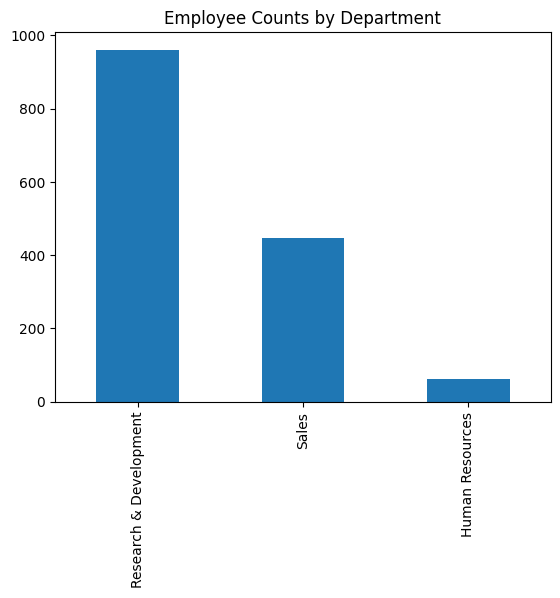

---------------------------------------------


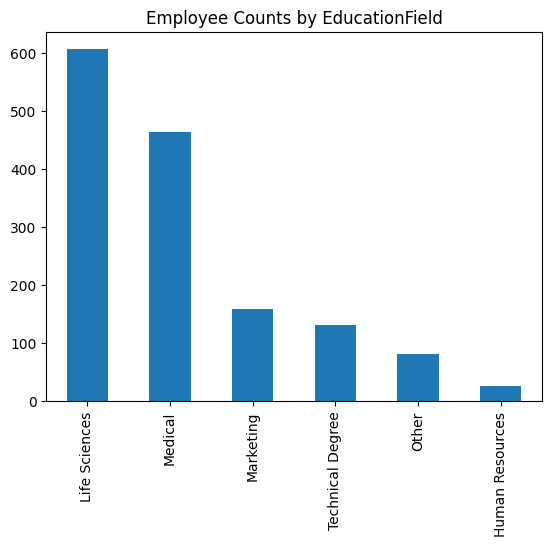

---------------------------------------------


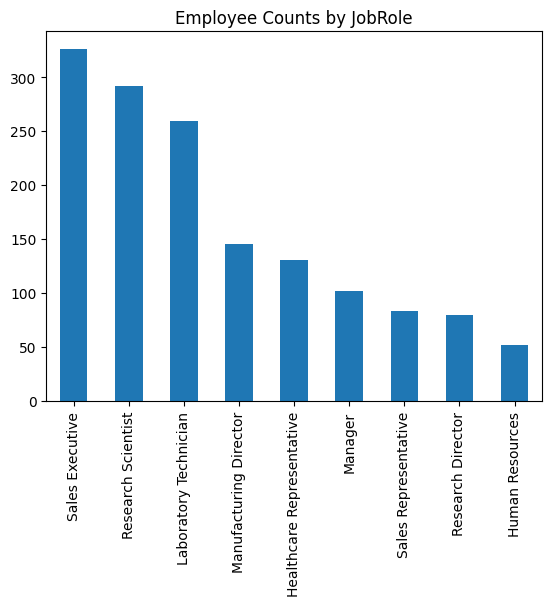

---------------------------------------------


In [84]:
## I didn't include these categorical variables in the df_train_eda dataframe I created, so I'm 
## referencing the entire original dataset. Not sure if that if we are supposed to do that. We can
## cut this entirely if it doesn't add value/is more trouble than it's worth to incorporate
categorical_features = ['Department', 'EducationField', 'JobRole']
for idx, f in enumerate(categorical_features):
    temp_df = df[f'{f}'].value_counts()
    temp_df.columns = [f'{f}', 'Counts']
    temp_df.plot(kind='bar')
    plt.title(f'Employee Counts by {f}')
    plt.show()
    print('-'*45)

### Heatmap

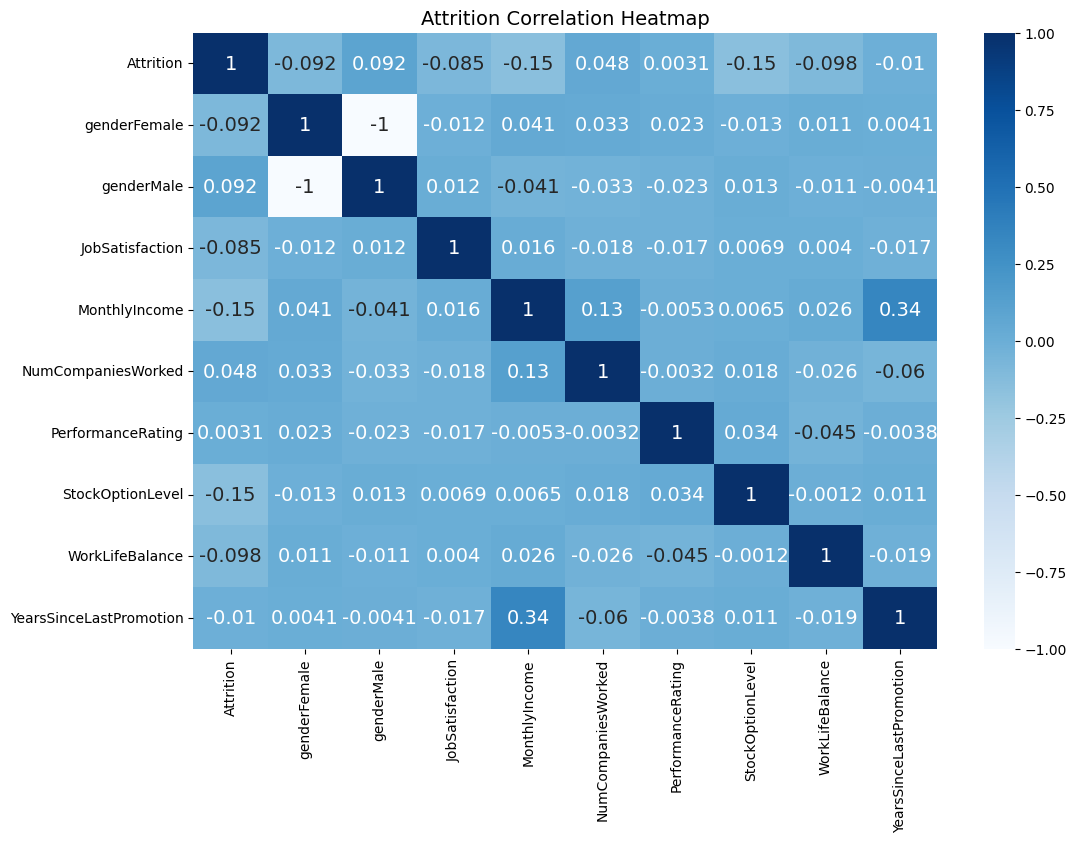

In [85]:
cm = df_train_eda[['Attrition', 'genderFemale', 'genderMale', 'JobSatisfaction', 
                   'MonthlyIncome','NumCompaniesWorked', 'PerformanceRating', 'StockOptionLevel',
                   'WorkLifeBalance', 'YearsSinceLastPromotion',]].corr()

fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(cm, 
            cmap='Blues', 
            xticklabels=True, 
            yticklabels=True, 
            annot=True, 
            annot_kws={"fontsize":14},
            cbar=True)
plt.title('Attrition Correlation Heatmap', fontsize=14)
plt.show()

# Baseline Model - Logistic Regression

For our baseline model we will train a logistic regression model to make a binary prediction of 1 (the employee will leave the company) or 0 (the employee will stay).

### Define a logistic regression model

In [86]:
def build_LR_model(num_features):
  """Return a simple logistic regression model using the Keras Sequential API."""
  # Clear session and set a random seed for consistent behavior.
  tf.keras.backend.clear_session()
  tf.random.set_seed(1234)
  np.random.seed(1234)
    

  # Use Keras Sequential API to build a logistic regression
  model = keras.Sequential()
    
  # create input layer
  model.add(tf.keras.Input(shape=(num_features,),
        name='Input'
  ))
  
  model.add(keras.layers.Dense(
      units=1,  
      use_bias=True,
      activation='sigmoid',
      #kernel_initializer='random_normal',
      #bias_initializer='zeros',
      kernel_initializer=initializers.RandomNormal(stddev=0.01),
      bias_initializer=initializers.RandomNormal(stddev=0.01),
      name="Output"
  ))

  # Use Binary Crossentropy as our loss and the SGD optimizer.
  
  model.compile(
      loss=tf.keras.losses.BinaryCrossentropy(),
      optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
      metrics=[tf.keras.metrics.BinaryAccuracy(),
               tf.keras.metrics.Recall()]
  )

  return model

### Build and fit model

We will build and fit a model on the subset of the training data that includes the following features: Age, EnvironmentSatisfaction, JobSatisfaction, StockOptionLevel, WorkLifeBalance, departmentResearch&Development, MonthlyIncome, PerformanceRating.

##### Build model

In [87]:
model_LR = build_LR_model(num_features = X_train_std_sub.shape[1])
model_LR.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Output (Dense)              (None, 1)                 8         
                                                                 
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


##### Fit model

In [88]:
tf.random.set_seed(1234)
np.random.seed(1234)

# define the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_recall',
    patience = 5,
    mode = 'max',
    verbose = 0,
    restore_best_weights = True
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = 'best_model.h5',
    monitor = 'val_recall',
    mode = 'max',
    save_best_only = True,
    save_weights_only = True,
    verbose = 0
)

# Train model
history_LR = model_LR.fit(x = X_train_std_sub,
                          y = y_train_sub,
                          shuffle = False,
                          #validation_split = 0.2,
                          validation_data=(X_val_std_sub, y_val_sub),
                          batch_size = len(X_train_std_sub),
                          epochs = 20,
                          #callbacks = [early_stopping, model_checkpoint],
                          verbose = 0
)

##### Show model history

In [89]:
history_LR = pd.DataFrame(history_LR.history)
display(history_LR)

,loss,binary_accuracy,recall,val_loss,val_binary_accuracy,val_recall
0,0.693543,0.489362,0.460526,0.692024,0.588983,0.394737
1,0.692255,0.560638,0.394737,0.690752,0.639831,0.315789
2,0.690975,0.623404,0.289474,0.689487,0.682203,0.289474
3,0.689700,0.679787,0.243421,0.688229,0.741525,0.263158
4,0.688433,0.731915,0.223684,0.686977,0.766949,0.184211
5,0.687172,0.767021,0.190789,0.685731,0.775424,0.157895
6,0.685917,0.794681,0.157895,0.684492,0.805085,0.131579
7,0.684668,0.818085,0.131579,0.683259,0.822034,0.105263
8,0.683427,0.828723,0.098684,0.682033,0.834746,0.078947
9,0.682191,0.834043,0.078947,0.680813,0.838983,0.078947


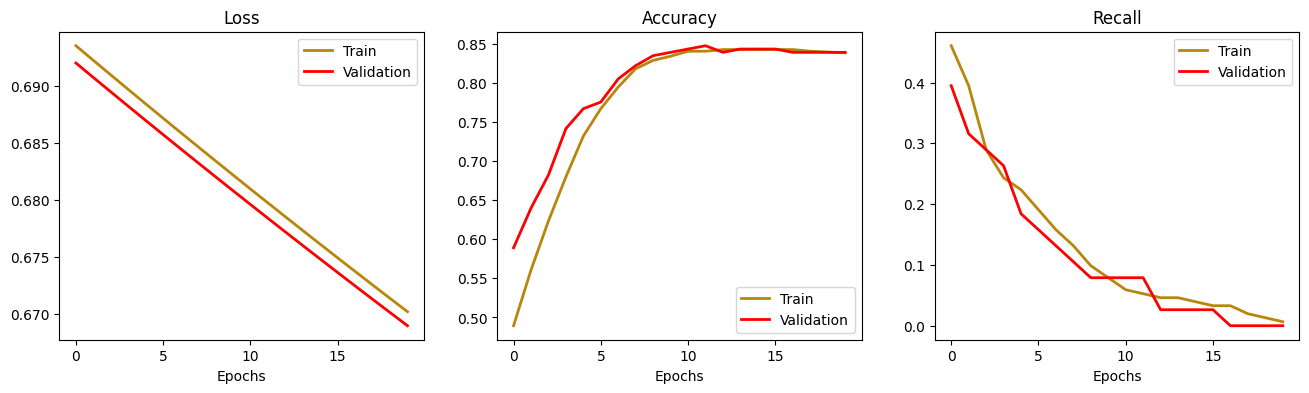

In [90]:
# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history_LR['loss'], lw=2, color='darkgoldenrod')
plt.plot(history_LR['val_loss'], lw=2, color='red')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 3, 2)
plt.plot(history_LR['binary_accuracy'], lw=2, color='darkgoldenrod')
plt.plot(history_LR['val_binary_accuracy'], lw=2, color='red')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Accuracy');

# plot recall for train and validation
ax = fig.add_subplot(1, 3, 3)
plt.plot(history_LR['recall'], lw=2, color='darkgoldenrod')
plt.plot(history_LR['val_recall'], lw=2, color='red')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Recall');

It appears our initial model achieved an accuracy of ~0.84 after 20 epochs, which is equivalent to a naive baseline of 84% (we know the turnover rate is 16%, so always predicting no turnover would result in 84% accuracy). However, this model achieved this accuracy at the expense of recall - indicating it was good at predicting the majority class while failing to properly classify employees that actually left the company. This is a problem for our analysis, which aims to help companies predict who might leave so they can avoid costly turnover.

Addressing the target variable class imbalance should improve our model's ability to predict both turnover and non-turnover employees. We will implement a hybrid upsampling/downsampling technique referred to as **SMOTE + ENN**:

- **SMOTE** (Synthetic Minority Over-sampling Technique) is an oversampling technique commonly used in machine learning to address class imbalance problems. It generates synthetic samples by interpolating new points between existing minority class examples.
- However, **SMOTE** can sometimes generate noisy samples that do not accurately represent the minority class. Therefore, the SMOTE algorithm can be combined with **ENN** (Edited Nearest Neighbours), a technique that removes noisy samples by analyzing the k-nearest neighbors of each sample.
- The **SMOTE + ENN** technique first applies SMOTE to oversample the minority class, then uses ENN to remove noisy samples generated by SMOTE. The ENN algorithm identifies noisy samples by examining the class labels of the k nearest neighbors of each sample. If the majority of the k nearest neighbors belong to a different class than the sample being examined, that sample is considered noisy and removed.

### Create SMOTE + ENN upsampled dataset

In [91]:
tf.random.set_seed(1234)
np.random.seed(1234)

# Print original training dataset sizes
print('X_train size - Before: ', X_train_std.shape)
print('y_train size - Before: ', y_train.shape)
print('X_val size - Before: ', X_val_std.shape)
print('y_val size - Before: ', y_val.shape)

# use SMOTE + ENN to oversample the train & validation dataset
smenn = SMOTEENN()
X_train_smenn, y_train_smenn = smenn.fit_resample(X_train_std, y_train)
X_val_smenn, y_val_smenn = smenn.fit_resample(X_val_std, y_val)

# Print the newly created dataset size
print('X_train_smenn size - After: ', X_train_smenn.shape)
print('y_train_smenn size - After: ', y_train_smenn.shape)
print('X_val_smenn size - After: ', X_val_smenn.shape)
print('y_val_smenn size - After: ', y_val_smenn.shape)

X_train size - Before:  (940, 39)
y_train size - Before:  (940,)
X_val size - Before:  (236, 39)
y_val size - Before:  (236,)
X_train_smenn size - After:  (1170, 39)
y_train_smenn size - After:  (1170,)
X_val_smenn size - After:  (298, 39)
y_val_smenn size - After:  (298,)


In [92]:
tf.random.set_seed(1234)
np.random.seed(1234)

# Print subset training dataset sizes
print('X_train_sub size - Before: ', X_train_std_sub.shape)
print('y_train_sub size - Before: ', y_train_sub.shape)
print('X_val_sub size - Before: ', X_val_std_sub.shape)
print('y_val_sub size - Before: ', y_val_sub.shape)

# use SMOTE + ENN to oversample the train dataset
smenn = SMOTEENN()
X_train_smenn_sub, y_train_smenn_sub = smenn.fit_resample(X_train_std_sub, y_train_sub)
X_val_smenn_sub, y_val_smenn_sub = smenn.fit_resample(X_val_std_sub, y_val_sub)

# Print the newly created dataset size
print('X_train_smenn_sub size - After: ', X_train_smenn_sub.shape)
print('y_train_smenn_sub size - After: ', y_train_smenn_sub.shape)
print('X_val_smenn_sub size - After: ', X_val_smenn_sub.shape)
print('y_val_smenn_sub size - After: ', y_val_smenn_sub.shape)

X_train_sub size - Before:  (940, 7)
y_train_sub size - Before:  (940,)
X_val_sub size - Before:  (236, 7)
y_val_sub size - Before:  (236,)
X_train_smenn_sub size - After:  (1078, 7)
y_train_smenn_sub size - After:  (1078,)
X_val_smenn_sub size - After:  (278, 7)
y_val_smenn_sub size - After:  (278,)


The y_train_smenn_sub array contains the labels (1 or 0) for our upsampled dataset. Taking the mean of the array will show whether the upsampled data is more balanced than our original dataset.

In [93]:
np.mean(y_train_smenn_sub)

0.5918367346938775

In [94]:
y_train_smenn_sub.shape

(1078,)

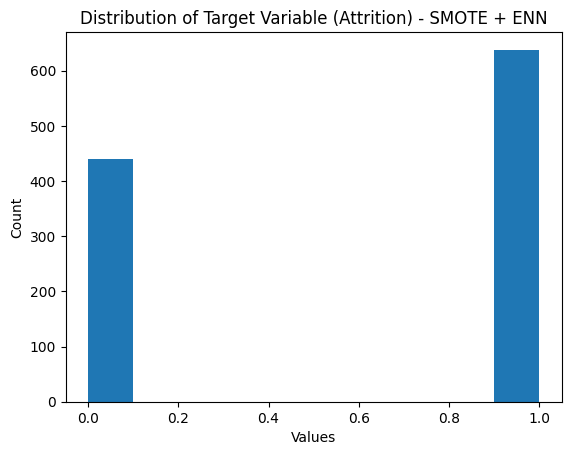

In [95]:
plt.hist(y_train_smenn_sub)
plt.xlabel('Values')
plt.ylabel('Count')
plt.title('Distribution of Target Variable (Attrition) - SMOTE + ENN')
plt.show()

It appears the SMOTE + ENN technique has correctly accounted for the original class imbalance in our data.

### Build and fit model - SMOTE & ENN

##### Build model

In [96]:
model_LR_smenn = build_LR_model(num_features = X_train_smenn_sub.shape[1])
model_LR_smenn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Output (Dense)              (None, 1)                 8         
                                                                 
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


##### Fit model

In [97]:
tf.random.set_seed(1234)
np.random.seed(1234)

# Train model
history_LR_smenn = model_LR_smenn.fit(x = X_train_smenn_sub,
                                      y = y_train_smenn_sub,
                                      shuffle = False,
                                      #validation_split = 0.2,
                                      validation_data=(X_val_smenn_sub, y_val_smenn_sub),
                                      batch_size = len(X_train_smenn_sub),
                                      epochs = 50,
                                      callbacks = [early_stopping, model_checkpoint],
                                      verbose = 0
)

##### Show model history

In [98]:
history_LR_smenn = pd.DataFrame(history_LR_smenn.history)
display(history_LR_smenn)

,loss,binary_accuracy,recall,val_loss,val_binary_accuracy,val_recall
0,0.693201,0.492579,0.358934,0.693323,0.525180,0.45000
1,0.691941,0.556586,0.463950,0.691990,0.568345,0.51875
2,0.690691,0.605751,0.547022,0.690666,0.593525,0.55000
3,0.689451,0.646568,0.622257,0.689353,0.629496,0.61875
4,0.688222,0.668831,0.669279,0.688049,0.690647,0.71250
5,0.687002,0.685529,0.699060,0.686754,0.719424,0.75625
6,0.685792,0.701299,0.731975,0.685470,0.766187,0.83125
7,0.684592,0.709647,0.749216,0.684195,0.769784,0.84375
8,0.683402,0.715213,0.768025,0.682930,0.780576,0.86250
9,0.682221,0.724490,0.783699,0.681674,0.787770,0.86875


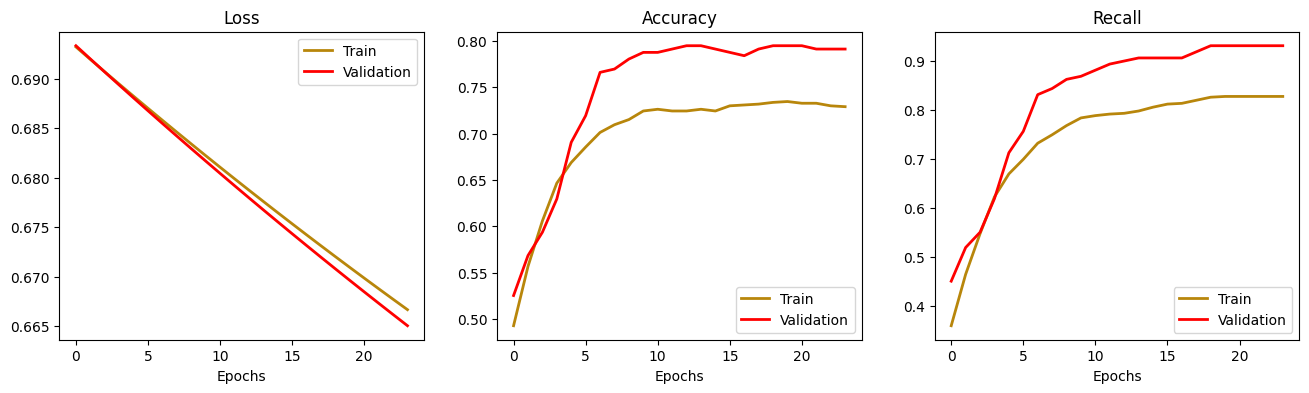

In [99]:
# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history_LR_smenn['loss'], lw=2, color='darkgoldenrod')
plt.plot(history_LR_smenn['val_loss'], lw=2, color='red')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 3, 2)
plt.plot(history_LR_smenn['binary_accuracy'], lw=2, color='darkgoldenrod')
plt.plot(history_LR_smenn['val_binary_accuracy'], lw=2, color='red')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Accuracy');

# plot recall for train and validation
ax = fig.add_subplot(1, 3, 3)
plt.plot(history_LR_smenn['recall'], lw=2, color='darkgoldenrod')
plt.plot(history_LR_smenn['val_recall'], lw=2, color='red')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Recall');

After upsampling/downsampling with SMOTE + ENN, we see a small decrease in accuracy (from ~0.84 to ~0.79) but a dramatic increase in recall (from 0.00 to ~0.93). The technique to balance the data appears to have dramatically increased the model's ability to accurately predict not only the employees who did not turnover, but most importantly, the employees who did.

### Logistic Regression Evaluation on Test Data 

In [100]:
# Predict the test data
LR_pred = model_LR_smenn.predict(X_test_std_sub)

# Evaluate the model on the test data
test_loss, test_acc, test_recall = model_LR_smenn.evaluate(X_test_std_sub, y_test_sub)

# Print the accuracy score
print('Accuracy:', test_acc)
print('Recall:', test_recall)

10/10 [==============================] - 0s 2ms/step - loss: 0.6934 - binary_accuracy: 0.4864 - recall: 0.8511
Accuracy: 0.4863945543766022
Recall: 0.8510638475418091


# Model 1: Decision Tree

### Define functions for information gain, entropy, parent distribution, and thresholds for binarization

In [101]:
def information_gain(data, labels, feature, threshold=0):
    ''' Computes information gain by splitting data based on the given feature and threshold.
    # param data: an array of featurized examples
    # param labels: an array of labels corresponding to the data
    # param feature: the feature to use to split the data
    # param threshold: the feature value to use to split the data (the default threshold is good for binary features)
    # returns: info gain
    '''
    # Get the initial entropy of the label distribution for the entire dataset.
    initial_entropy = entropy(get_parent_distribution(labels))
    
    # subset0 will contain the labels for which the feature is 0 (the employee will stay) and
    # subset1 will contain the labels for which the feature is 1 (the employee will leave the company).
    subset0, subset1 = [], []
    for datum, label in zip(data, labels):
        if datum[feature] > threshold:
            subset1.append(label)
        else: 
            subset0.append(label)
    
    # Compute the entropy of each subset.
    subset0_entropy = entropy(get_parent_distribution(subset0))
    subset1_entropy = entropy(get_parent_distribution(subset1))
    
    # Compute the final entropy by weighing each subset's entropy according to its size.
    subset0_weight = 1.0 * len(subset0) / len(labels)
    subset1_weight = 1.0 * len(subset1) / len(labels)
    final_entropy = subset0_weight * subset0_entropy + subset1_weight * subset1_entropy
    
    # Finally, compute information gain as the difference between the initial and final entropy.
    return initial_entropy - final_entropy



def entropy(distribution):
    ''' Computes the entropy index 
    # param distribution: list containing distributions
    # return entropy index
    '''
    entropy_index = 0.0
    for probability in distribution:
        log_prob = -100.0  # log(0) = -inf so let's approximate it with -100 to avoid an error
        if probability > 0.0: 
            log_prob = np.log2(probability)
        entropy_index -= probability * log_prob
        
    return entropy_index



def get_parent_distribution(labels):
    ''' Computes relative frequency of each class label in the parent dataset
    # param labels: an array of labels corresponding to the data
    # return: an array containing the normalized count of each unique label
    '''
    # Initialize counters for all labels to zero.
    label_counts = np.array([0.0 for i in range(len(np.unique(labels)))])

    # Iterate over labels in the training data and update counts.
    for label in labels:
        label_counts[label] += 1.0
    
    # Normalize to get a distribution.
    label_probs = label_counts / label_counts.sum()
    
    return label_probs
  

  
def try_features_and_thresholds(data, labels):
    ''' Computes thresholds for each features and returns the threshold that optimizes information gain
    # param labels: an array of labels corresponding to the data
    # print: best threshold and information gain for the feature
    '''
    # Print header of the output table.
    print('feature', 'best_threshold', 'best_IG', 'feature name')

    # Iterate over all features.
    for feature in range(data.shape[1]):
        # Choose a set of thresholds between the min- and max-valued feature, ignoring the min and max themselves.
        thresholds = np.linspace(data[:,feature].min(), data[:,feature].max(), 20)[1:-1]

        # Try each threshold and keep track of the best one for this feature.
        best_threshold = 0
        best_IG = 0
        for threshold in thresholds:
            IG = information_gain(data, labels, feature, threshold)
            if IG > best_IG:
                best_IG = IG
                best_threshold = threshold

        # Show the best threshold and information gain for this feature.
        print ('%d %.3f %.3f %s' %(feature, best_threshold, best_IG, all_features[feature]))

### Utilize threshold values to binarize the features

In [102]:
# Initialize empty list to store binarization threshold values for each feature
binarize_threshold = []

# Concatenate datasets into separate dataframes
df_b_train = pd.concat(
    [pd.DataFrame(y_train_smenn), pd.DataFrame(X_train_smenn)],
    axis=1
)

df_b_val = pd.concat(
    [pd.DataFrame(y_val_smenn), pd.DataFrame(X_val_smenn)],
    axis=1
)

df_b_test = pd.concat(
    [pd.DataFrame(y_test), pd.DataFrame(X_test_std)],
    axis=1
)

features_eda = all_features.copy()
features_eda.insert(0, 'Attrition')


# Rename columns
df_b_test.columns = features_eda
df_b_train.columns = features_eda
df_b_val.columns = features_eda

# Add label column

df_b_test['split_type'] = 'test'
df_b_train['split_type'] = 'train'
df_b_val['split_type'] = 'validation'

#create single dataframe prior to binarization 
df_b = pd.concat([df_b_train, df_b_test, df_b_val])

df_b.shape

# Loop through features and binarize the values.  
# Values above the mean are set to 1, values below the mean are set to 0
for feature in all_features:
  df_b[feature] = np.where(df_b[feature] >= df_b[feature].mean(), 1, 0)
  binarize_threshold.append(df_b[feature].mean())

df_b.head()




,Attrition,Age,BusinessTravel,DistanceFromHome,Education,EnvironmentSatisfaction,JobLevel,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,StockOptionLevel,TotalWorkingYears,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,departmentHumanResources,departmentResearch&Development,departmentSales,educationfieldHumanResources,educationfieldLifeSciences,educationfieldMarketing,educationfieldMedical,educationfieldOther,educationfieldTechnicalDegree,genderFemale,genderMale,jobroleHealthcareRepresentative,jobroleHumanResources,jobroleLaboratoryTechnician,jobroleManager,jobroleManufacturingDirector,jobroleResearchDirector,jobroleResearchScientist,jobroleSalesExecutive,jobroleSalesRepresentative,split_type
0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,1,1,1,1,1,1,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,train
1,0,1,0,0,0,0,0,1,0,1,0,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,train
2,0,1,1,0,1,0,1,0,1,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,train
3,0,1,0,0,1,1,1,1,1,1,0,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,train
4,0,1,0,1,0,1,1,1,1,1,0,0,0,1,1,1,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,train


In [103]:
# Extract the binary features and labels from the 
# corresponding dataframes and store in arrays.

df_b_train = df_b[df_b['split_type'] == 'train']
df_b_val = df_b[df_b['split_type'] == 'validation']
df_b_test = df_b[df_b['split_type'] == 'test']

# Remove split_type text column as it is no longer needed

df_b_train.drop('split_type', axis=1, inplace=True)
df_b_test.drop('split_type', axis=1, inplace=True)
df_b_val.drop('split_type', axis=1, inplace=True)

X_b_train = np.array(df_b_train.iloc[:, 1:])
y_b_train = np.array(df_b_train.iloc[:, 0])

X_b_test = np.array(df_b_test.iloc[:, 1:])
y_b_test = np.array(df_b_test.iloc[:, 0])

X_b_val = np.array(df_b_val.iloc[:, 1:])
y_b_val = np.array(df_b_val.iloc[:, 0])


<ipython-input-103-dcf85b271fea>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b_train.drop('split_type', axis=1, inplace=True)
<ipython-input-103-dcf85b271fea>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b_test.drop('split_type', axis=1, inplace=True)
<ipython-input-103-dcf85b271fea>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b_val.drop('split_type', axis=1, inplace=True)


### Calculate entropy

In [104]:
# Compute parent distribution.
label_probs = get_parent_distribution(y_b_train)
print ('Parent distribution', label_probs)

# Compare the label entropy to a uniform distribution.
print ('Parent entropy:', entropy(label_probs))
print ('Uniform entropy:', entropy([1./2, 1./2])) # indicating all classes have equal probability

Parent distribution [0.35470085 0.64529915]
Parent entropy: 0.9381963929172437
Uniform entropy: 1.0


Comparing the parent entropy value of ~0.94 to the entropy value of 1.0 for a uniform distribution (where all classes have equal probability, therefore entropy is maxed out) indicates that the parent distribution has no clear majority class.

### Calculate information gain 

In [105]:
# Create list to store values.
ig_scores = []

# Iterate for all features and compute info gain.
for feature in range(len(all_features)):
    ig_score = information_gain(X_b_train, y_b_train, feature)
    ig_scores.append((ig_score, all_features[feature]))

# Sort the features by info gain score.   
ig_scores_sorted = sorted(ig_scores, reverse=True)

# Print the feature's info gain and name.    
for ig_score, feature_name in ig_scores_sorted:
    print('%.3f %s' %(ig_score, feature_name))


0.092 OverTime
0.082 StockOptionLevel
0.075 JobLevel
0.059 TotalWorkingYears
0.052 jobroleResearchDirector
0.045 departmentResearch&Development
0.042 educationfieldTechnicalDegree
0.041 YearsInCurrentRole
0.041 jobroleManager
0.040 Age
0.039 MonthlyIncome
0.039 jobroleSalesRepresentative
0.037 BusinessTravel
0.035 departmentSales
0.028 jobroleLaboratoryTechnician
0.028 YearsAtCompany
0.028 DistanceFromHome
0.026 YearsWithCurrManager
0.026 WorkLifeBalance
0.024 EnvironmentSatisfaction
0.021 jobroleHumanResources
0.014 jobroleSalesExecutive
0.014 genderMale
0.014 genderFemale
0.013 jobroleHealthcareRepresentative
0.012 educationfieldMarketing
0.011 jobroleManufacturingDirector
0.008 JobSatisfaction
0.008 educationfieldLifeSciences
0.008 departmentHumanResources
0.004 Education
0.003 educationfieldHumanResources
0.001 educationfieldMedical
0.001 YearsSinceLastPromotion
0.001 educationfieldOther
0.000 PercentSalaryHike
0.000 jobroleResearchScientist
0.000 NumCompaniesWorked
0.000 Performan

### Train the Decision Tree Model with different depths and measure performance

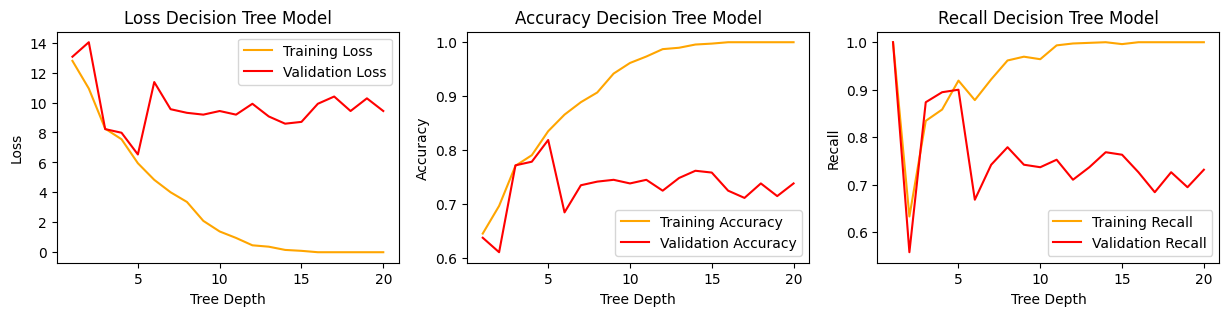

In [106]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Create list of depths to train on.
depths = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

# Create empty lists to store metrics.
train_accuracy = []
validation_accuracy = []
train_recall = []
validation_recall = []
train_loss = []
validation_loss = []

# Utilize the Decision Tree Classifier to create new models at different depths.
for depth in depths:
    dt = DecisionTreeClassifier(criterion='entropy', max_depth=depth)

    # Fit decision tree classifier on training set.
    dt.fit(X_b_train, y_b_train)
    
    # Calculate training and validation accuracy and append to lists.
    train_accuracy.append(dt.score(X_b_train, y_b_train))
    validation_accuracy.append(dt.score(X_b_val, y_b_val))
    
    # Predict target values.
    y_train_pred = dt.predict(X_b_train)
    y_val_pred = dt.predict(X_b_val)

    # Calculate training and validation recall and append to lists.
    train_recall.append(recall_score(y_b_train, y_train_pred))
    validation_recall.append(recall_score(y_b_val, y_val_pred))
    
    # Calculate training and validation log loss and append to lists.
    train_loss.append(log_loss(y_b_train,y_train_pred))
    validation_loss.append(log_loss(y_b_val,y_val_pred))

fig, axs = plt.subplots(1, 3, figsize=(15, 3))

# Plot Loss
axs[0].plot(depths, train_loss, label='Training Loss', color = 'orange')
axs[0].plot(depths, validation_loss, label='Validation Loss', color = 'red')
axs[0].set_xlabel('Tree Depth')
axs[0].set_title('Loss Decision Tree Model')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot Accuracy
axs[1].plot(depths, train_accuracy, label='Training Accuracy', color = 'orange')
axs[1].plot(depths, validation_accuracy, label='Validation Accuracy', color = 'red')
axs[1].set_xlabel('Tree Depth')
axs[1].set_title('Accuracy Decision Tree Model')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Plot Recall
axs[2].plot(depths, train_recall, label='Training Recall', color = 'orange')
axs[2].plot(depths, validation_recall, label='Validation Recall', color = 'red')
axs[2].set_xlabel('Tree Depth')
axs[2].set_title('Recall Decision Tree Model')
axs[2].set_ylabel('Recall')
axs[2].legend()

# Display all plots.
plt.show()

### Decision Tree Classifier - Evaluation on Test Data 

In [107]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=5)
dt.fit(X_b_train, y_b_train)

print('Accuracy:', dt.score(X_b_test, y_b_test))


y_pred = dt.predict(X_b_test)
recall = recall_score(y_b_test, y_pred)


print('Recall:', recall)

Accuracy: 0.5544217687074829
Recall: 0.9361702127659575


### Decision Tree Classifier - Graph of Tree 

Features: ['Age', 'BusinessTravel', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'StockOptionLevel', 'TotalWorkingYears', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'departmentHumanResources', 'departmentResearch&Development', 'departmentSales', 'educationfieldHumanResources', 'educationfieldLifeSciences', 'educationfieldMarketing', 'educationfieldMedical', 'educationfieldOther', 'educationfieldTechnicalDegree', 'genderFemale', 'genderMale', 'jobroleHealthcareRepresentative', 'jobroleHumanResources', 'jobroleLaboratoryTechnician', 'jobroleManager', 'jobroleManufacturingDirector', 'jobroleResearchDirector', 'jobroleResearchScientist', 'jobroleSalesExecutive', 'jobroleSalesRepresentative']
Feature importances: [0.         0.         0.         0.         0.         0.15635222
 0.      

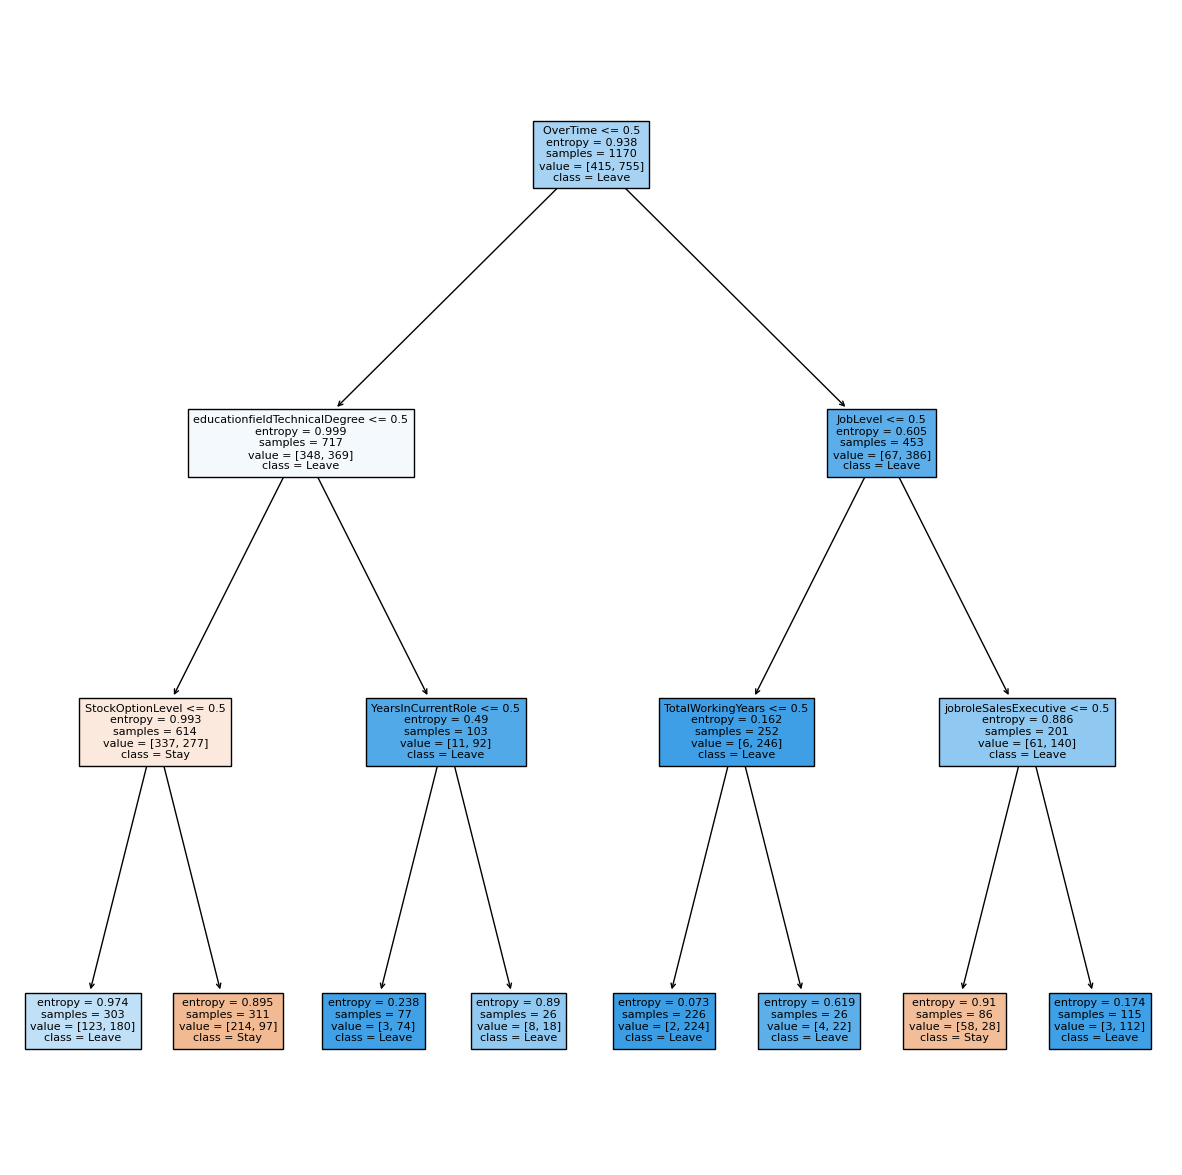

In [108]:
# Create decision tree classifier with max depth of 3.
dt = DecisionTreeClassifier(criterion='entropy', max_depth=3)

# Fit the decision tree ot the training data.
clf = dt.fit(X_b_train, y_b_train)

# Visualize the decision tree.
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (15,15), dpi=100)
tree.plot_tree(clf, feature_names=all_features, class_names=['Stay', 'Leave'], filled=True,  fontsize=8)


# List the features and their importances
print('Features:', all_features)
print ('Feature importances:', dt.feature_importances_)

By limiting the decision tree's depth to 3, we are able to create a good visualization of what the model is doing. In this case, we see that the four most important features in predicting employee attrition for this model (tree depth = 3) in order of importance are: "Stock Option Level", "Overtime", "Job Role Lab Technician."

[[119 128]
 [  3  44]]

 Classification Report for Decision Tree Model on Test Set:

               precision    recall  f1-score   support

           0       0.98      0.48      0.64       247
           1       0.26      0.94      0.40        47

    accuracy                           0.55       294
   macro avg       0.62      0.71      0.52       294
weighted avg       0.86      0.55      0.61       294



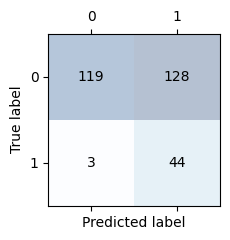

In [109]:
# Confusion matrix function
def confusion_matrix_plot(conf_matrix):
    """ Confusion matrix matplotlib plot
    # param conf_matrix: nested list of TP, TN, FP, FN
    # return: None
    """
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.show()

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred) # confusion_matrix is available in sklearn.metrics
print(conf_matrix)

# Classification report
print('\n Classification Report for Decision Tree Model on Test Set:\n\n', classification_report(y_test, y_pred))

# Plot confusion matrix
confusion_matrix_plot(conf_matrix)


# Model 2: KNN

### Fit Model on Training Set & Predict Labels on Validation Set

In [110]:
# Print the newly created dataset size
print('X_train_smenn_sub size - After: ', X_train_smenn_sub.shape)
print('y_train_smenn_sub size - After: ', y_train_smenn_sub.shape)
print('X_val_smenn_sub size - After: ', X_val_smenn_sub.shape)
print('y_val_smenn_sub size - After: ', y_val_smenn_sub.shape)
print('X_test_std_sub size: ', X_test_std_sub.shape)
print('y_test_sub size: ',  y_test_sub.shape)


X_train_smenn_sub size - After:  (1078, 7)
y_train_smenn_sub size - After:  (1078,)
X_val_smenn_sub size - After:  (278, 7)
y_val_smenn_sub size - After:  (278,)
X_test_std_sub size:  (294, 7)
y_test_sub size:  (294,)


In [111]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Create a KNN classifier with k=3 - use GridSearchCV for best hyperparameters
params = {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
knn = KNeighborsClassifier(**params)

# Train the classifier on the training set
knn.fit(X_train_smenn_sub, y_train_smenn_sub)

# Predict the labels of the validation set
y_val_pred = knn.predict(X_val_smenn_sub)

# Calculate the KNN log loss on the validation set
knn_log_loss = log_loss(y_val_smenn_sub, y_val_pred)
print(f"KNN log loss for validation set: {knn_log_loss:.3f}")

# Calculate the KNN accuracy on the validation set
accuracy = accuracy_score(y_val_smenn_sub, y_val_pred)
print(f"KNN accuracy score for validation set: {accuracy:.3f}")


KNN log loss for validation set: 8.427
KNN accuracy score for validation set: 0.766


### Use sklearn.model_selection.GridSearchCV for Hyperparameters Tunings. The below URLs are for references. 
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html<br>
https://towardsdatascience.com/gridsearchcv-for-beginners-db48a90114ee

In [112]:
# KNN hyperparameters tuning on training set using GridSearchCV
from sklearn.model_selection import GridSearchCV

model = KNeighborsClassifier()

# Define the hyperparameters to tune
params = {'n_neighbors': [3, 5, 7, 9, 11, 20, 30],
          'weights': ['uniform', 'distance'],
          'metric': ['euclidean', 'manhattan', 'minkowski']}

# Create a grid search object
grid_search = GridSearchCV(model, params, cv=5)

# Fit the grid search object to the training data
grid_search.fit(X_train_smenn_sub, y_train_smenn_sub)

print("KNN hyperparameters tuning using GridSearchCV: ")
print("----------------------------------------------")

# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)

# Print the accuracy for KNN model on training set
print(f"Accuracy: {grid_search.best_score_:.3f}")

KNN hyperparameters tuning using GridSearchCV: 
----------------------------------------------
Best hyperparameters:  {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Accuracy: 0.978


### Predict on Test Set

In [113]:
# Predict the labels of the test data
y_test_pred = knn.predict(X_test_std_sub)

# Calculate the KNN log loss on test set
knn_log_loss_test = log_loss(y_test_sub, y_test_pred)
print(f"KNN log loss for test set: {knn_log_loss_test:.3f}")

# Calculate the KNN accuracy on test set
accuracy_test = accuracy_score(y_test_sub, y_test_pred)
print(f"KNN accuracy score for test set: {accuracy_test:.3f}")


KNN log loss for test set: 11.647
KNN accuracy score for test set: 0.677


###  KNN Evaluation using Confusion Matrix & Classification Report

#### Recall Score Formula

Image source: Python Machine Learning 3rd Edition by [Sebastian Raschka] 



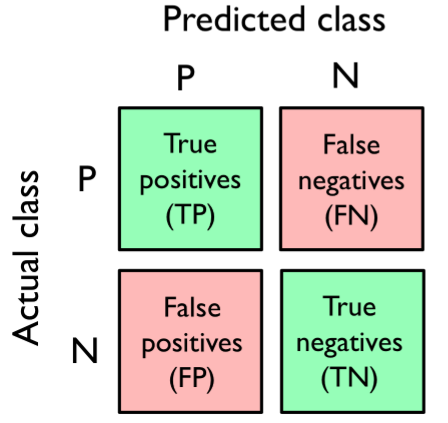

In [114]:
# The image is from live session Week 7: The KNN classifer. 
print('Image source: Python Machine Learning 3rd Edition by [Sebastian Raschka] \n')
Image(filename='/content/drive/MyDrive/207-MachineLearning/207_final_project/images/confusion_matrix.png', width=200)

The **recall** metrics are related to the TP and TN rates, as follows:

$recall = \frac{TP}{TP+FN}$, minimizes the chance of not detecting a FN, but doesn't pay attention to FP.

In [115]:
# Confusion matrix function
def confusion_matrix_plot(conf_matrix):
    """ Confusion matrix matplotlib plot
    # param conf_matrix: nested list of TP, TN, FP, FN
    # return: None
    """
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.show()

In [116]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test_sub, y_test_pred) # confusion_matrix is available in sklearn.metrics
print(conf_matrix)

# Classification report
print('\n Classification Report for KNN Model on Test Set:\n\n', classification_report(y_test_sub, y_test_pred))

[[168  79]
 [ 16  31]]

 Classification Report for KNN Model on Test Set:

               precision    recall  f1-score   support

           0       0.91      0.68      0.78       247
           1       0.28      0.66      0.39        47

    accuracy                           0.68       294
   macro avg       0.60      0.67      0.59       294
weighted avg       0.81      0.68      0.72       294



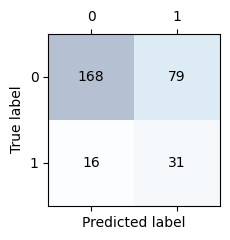

In [117]:
# Plot confusion matrix
confusion_matrix_plot(conf_matrix)

In [118]:
# Extract accuracy and recall scores from the classification report for easy review

report = classification_report(y_test_sub, y_test_pred)

# Extract accuracy and recall scores
report_lines = report.split('\n')
accuracy = float(report_lines[5].split()[-2])
recall = float(report_lines[7].split()[-3])

# Print accuracy and recall scores
print(f"Accuracy score: {accuracy:.2f}")
print(f"Recall score (weighted avg): {recall:.2f}")

Accuracy score: 0.68
Recall score (weighted avg): 0.68
